In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error as mse
from matplotlib import pyplot as plt

from tqdm import tqdm

In [2]:
krx = '/data/hun/KRX_marketdata/'

In [3]:
tickers = pd.read_csv(krx+'ticker_recent.csv', encoding ='cp949')
tickers.columns = ('full_ticker', 'ticker', 'name_full', 'name',
              'name_eng', 'listed_data', 'market', 'security_category',
              'related_department', 'preferred', 'face_value', 'shares')
tickers = tickers.drop(['related_department'], axis=1).dropna().reset_index(drop=True)

In [4]:
factors= pd.read_csv(krx+'factors.csv')
factors['ticker'] = factors.ticker.apply(lambda x: '0'*(6-len(str(x)))+str(x))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
factors =factors.dropna()

In [6]:
factors.reset_index(drop = True, inplace = True)

### Preprocessing


In [8]:
def xvar(data):
    return data.drop(['date','ticker','name'], axis=1).astype('float')

In [9]:
def xy(data):
    return data.drop(['ret'], axis=1), data.ret

In [10]:
dates = factors.date.unique()[::-1]

# Pooling

In [11]:
#preprocessing

length = len(dates)
ind_train = int(length*0.7)+2
ind_tv = int(length*0.4)
# pool_train_pre = factors[factors.date.apply(lambda x: x in dates[0:ind_train])]
# pool_test = factors[factors.date.apply(lambda x: x in dates[ind_train:])]

In [12]:
dates[ind_tv], dates[ind_train]

('2010/01', '2016/01')

In [13]:
## Time series split

pool_train = []
pool_val = []
pool_test = []
cnt = ind_tv
start= 0
for i in tqdm(range(12)):
    train_ind = dates[start:cnt-12]
    val_ind = dates[cnt-12:cnt]
    test_ind = dates[cnt:min(cnt+12, length)]
    
    pool_train.append(xvar(factors[factors.date.apply(lambda x: x in train_ind)]))
    pool_val.append(xvar(factors[factors.date.apply(lambda x: x in val_ind)]))
    pool_test.append(xvar(factors[factors.date.apply(lambda x: x in test_ind)]))
    cnt += 12

100%|██████████| 12/12 [01:22<00:00,  6.90s/it]


# Neural net

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [15]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.x_data=torch.FloatTensor(X.values)
        self.y_data=torch.FloatTensor(Y.values.reshape(-1,1))
    def __len__(self):     #len(dataset)으로 호출 가능
        return len(self.x_data)
    def __getitem__(self,idx):   #dataset[]으로 callable하게 된다
        x=self.x_data[idx]
        y=self.y_data[idx]
        return x, y

from sklearn.preprocessing import StandardScaler
def stdscaler(data_tensor):
    scalers = {}
    for i in range(data_tensor.shape[0]): #batch값을 넣어주기
        scalers[i] = StandardScaler()
        data_tensor[i, :, :] = torch.tensor(scalers[i].fit_transform(data_tensor[i, :, :]))
    return data_tensor


In [16]:
cuda = torch.cuda.is_available() # False
if cuda:
    device = 'cuda:3'
else:
    device = 'cpu'
cuda, device

(True, 'cuda:3')

### FC Models

In [17]:
class Net1(nn.Module):
    def __init__(self):
        self.name = 'Net1'
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(19,16)
        self.fc2 = nn.Linear(16,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Net2(nn.Module):
    def __init__(self):
        self.name = 'Net2'
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(19,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)
        return x

class Net3(nn.Module):
    def __init__(self):
        self.name = 'Net3'
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(19,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,4)
        self.fc4 = nn.Linear(4,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        return x
    
class Net4(nn.Module):
    def __init__(self):
        self.name = 'Net4'
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(19,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,4)
        self.fc4 = nn.Linear(4,2)
        self.fc5 = nn.Linear(2,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

class Net5(nn.Module):
    def __init__(self):
        self.name = 'Net5'
        super(Net5, self).__init__()
        self.fc1 = nn.Linear(19,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,8)
        self.fc4 = nn.Linear(8,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [18]:
class Net6(nn.Module):
    def __init__(self):
        self.name = 'Net6'
        super(Net6, self).__init__()
        self.fc1 = nn.Linear(19,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,16)
        self.fc4 = nn.Linear(16,8)
        self.fc5 = nn.Linear(8,4)
        self.fc6 = nn.Linear(4,2)
        self.fc7 = nn.Linear(2,1)
        
        self.fc8 = nn.Linear(19,16)
        self.fc9 = nn.Linear(16,8)
        self.fc10 = nn.Linear(8,4)
        self.fc11 = nn.Linear(4,2)
        self.fc12 = nn.Linear(2,1)
        
        self.fc13 = nn.Linear(8,4)
        self.fc14 = nn.Linear(4,2)
        self.fc15 = nn.Linear(2,1)
        
        self.res = nn.Linear(3,1)
        
    def forward(self, x):
        x1 = F.relu(self.fc1(x))
        x1 = F.relu(self.fc2(x1)) 
        x1 = F.relu(self.fc3(x1))
        x1 = F.relu(self.fc4(x1))
        x1 = F.relu(self.fc5(x1))
        x2 = F.relu(self.fc6(x1))
        x2 = self.fc7(x2)
        
        y1 = F.relu(self.fc8(x))
        y1 = F.relu(self.fc9(y1))
        y1 = F.relu(self.fc10(y1))
        y2 = F.relu(self.fc11(y1))
        y2 = self.fc12(y2)
        
        z=torch.cat((x1,y1),1)
        
        z = F.relu(self.fc13(z))
        z = F.relu(self.fc14(z))
        z = self.fc15(z)
        
        fin = self.res(torch.cat((x2, y2, z),1))
        
        return fin

In [19]:
def ros_nn(model, CustomData):
    model.eval()
    pred = model(CustomData.x_data.to(device)).cpu().detach().numpy().reshape(-1)
    real = CustomData.y_data.numpy().reshape(-1)
    ros = 1- ((pred - real)**2).mean()/(real**2).mean()
    return ros, pred

In [22]:
def loss_hun(output, real):
    temp=output-real
#     bear_bull=(real>0)*(output<0)*temp
    bull_bear=(real<0)*(output>0)*temp
#     bear=(real<0)*temp
    bull=(real>0)*temp
    return ((bull_bear+bull)**2).sum()

In [32]:
def torch_train(model, train_loader, valid_loader, period, ite = 700, lr = 0.01):
#     criterion = torch.nn.MSELoss()
    criterion = loss_hun
    optimizer = optim.RAdam(model.parameters(), lr=lr ) #, lr_decay=1e-9)
    
    loss_array_train = []
    loss_array_valid = []
    
    patience = 0
    min_loss = np.inf

    for i in tqdm(range(ite)):
        loss_array_train_tmp = []
        
        model.train()
        for batch_idx, samples in enumerate(train_loader):
            trainX_tensor, trainY_tensor=samples
            optimizer.zero_grad()
            out = model(trainX_tensor.to(device))
            loss = criterion(out, trainY_tensor.to(device))
            loss.backward()
            optimizer.step()
            loss_array_train_tmp.append(loss.item())
        loss_array_train.append(np.mean(loss_array_train_tmp))    

        torch.cuda.empty_cache() ## 캐시 비워주기 자주 해줘야함

        model.eval()
        loss_array_valid_tmp = []
        with torch.no_grad():
            for batch_idx, val_samples in enumerate(valid_loader):
                validX_tensor, validY_tensor=val_samples
                val_out = model(validX_tensor.to(device))
                val_loss = criterion(val_out, validY_tensor.to(device))
                loss_array_valid_tmp.append(val_loss.item())
            loss_array_valid.append(np.mean(loss_array_valid_tmp))

        ## update the minimum loss
        if min_loss > loss_array_valid[-1]:
            patience = 0
            min_loss = loss_array_valid[-1]
        else:
            patience += 1
        if patience > 20: ## early stop when patience become larger than 10
            break

        torch.cuda.empty_cache()
    
    path = f"./NN_save/{model.name}_{period}"
    torch.save(model, path+"_RAdam")
    
    train_loss, valid_loss = loss_array_train[-1], loss_array_valid[-1]
    print('Model: {}, Train Loss: {:.4e}, Valid Loss: {:.4e}'.format(model.name, train_loss, valid_loss))
    print(patience)
    plt.plot(loss_array_train, label='Train Loss')
    plt.plot(loss_array_valid, label='Valid Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    torch.cuda.empty_cache()
    return model, valid_loss, train_loss

# Training

In [28]:
nets = [Net1(), Net2(), Net3(), Net4(), Net5()]

## Testing

In [28]:
results = pd.DataFrame(columns = ['model','period','r_squared','valid_loss','train_loss'])
results.to_csv('NN_test_res_rolling0_11_start0_adagrad.csv', index = False)
model_name = [i.name for i in nets]
preds = pd.DataFrame(columns = model_name)
preds.to_csv('NN_test_pred0_11_start0_adagrad.csv', index = False)

for period in range(8,12):
    train_set, val_set, test_set = pool_train[period], pool_val[period], pool_test[period]
    train_x, train_y = xy(train_set)
    val_x, val_y = xy(val_set)
    test_x, test_y = xy(test_set)
    
    train_data, valid_data = CustomDataset(train_x,train_y), CustomDataset(val_x, val_y)
    test_data = CustomDataset(test_x, test_y)
    
    train_loader = DataLoader(train_data, batch_size=120, shuffle=False, pin_memory=True)
    valid_loader = DataLoader(valid_data, batch_size=120, shuffle=False, pin_memory=True)
    
    r_squared, valid_loss, train_loss =[], [], []
    predicted = []
    for model in nets:
        model = model.to(device)
        model_trained, val_loss, tr_loss = torch_train(model, train_loader, valid_loader, period)
        valid_loss.append(val_loss)
        train_loss.append(tr_loss)
        
        r_sq, pred_res = ros_nn(model, test_data)
        r_squared.append(r_sq)
        predicted.append(pred_res)
        print(r_sq)

    res_temp = pd.DataFrame({"model": model_name, "period": [period]*5, "r_squared": r_squared, 
                             "valid_loss": valid_loss, "train_loss": train_loss})
    
    pred_temp = pd.DataFrame({"Net1":predicted[0], "Net2":predicted[1], "Net3":predicted[2], 
                              "Net4":predicted[3], "Net5":predicted[4]})
    
    res_temp.to_csv('NN_test_res_rolling0_11_start0_adagrad.csv', index = False, header = False, mode ='a')
    pred_temp.to_csv('NN_test_pred0_11_start0_adagrad.csv', index = False, header = False, mode ='a')


NameError: name 'nets' is not defined

In [33]:
net6 = Net6()

  4%|▍         | 31/700 [04:25<1:35:31,  8.57s/it]


Model: Net6, Train Loss: 3.1928e+02, Valid Loss: 3.3498e+01
21


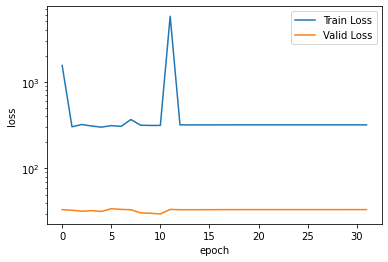

0.0008104443550109863


  6%|▋         | 44/700 [08:43<2:10:06, 11.90s/it]


Model: Net6, Train Loss: 2.8506e+02, Valid Loss: 6.0823e+01
21


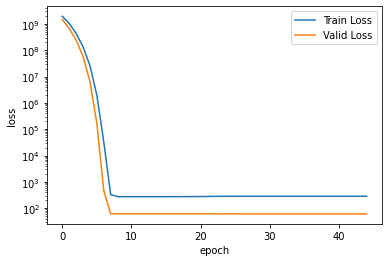

-0.010148286819458008


  3%|▎         | 20/700 [05:07<2:54:19, 15.38s/it]


Model: Net6, Train Loss: nan, Valid Loss: nan
21


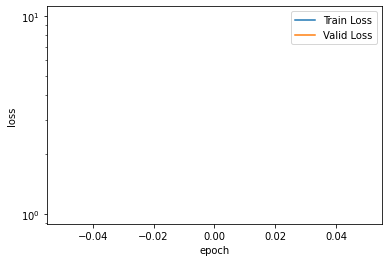

  0%|          | 0/700 [00:00<?, ?it/s]

nan


  3%|▎         | 20/700 [05:26<3:05:01, 16.33s/it]


Model: Net6, Train Loss: nan, Valid Loss: nan
21


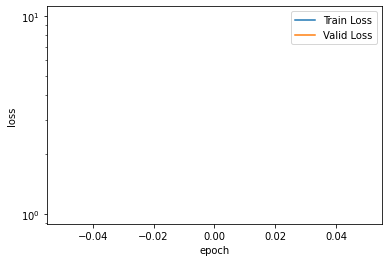

nan


  3%|▎         | 20/700 [06:20<3:35:42, 19.03s/it]


Model: Net6, Train Loss: nan, Valid Loss: nan
21


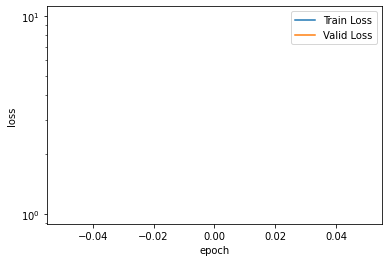

nan


  1%|          | 6/700 [02:15<4:21:03, 22.57s/it]


KeyboardInterrupt: 

In [34]:
results = pd.DataFrame(columns = ['model','period','r_squared','valid_loss','train_loss'])
results.to_csv('NN_test_res_net6.csv', index = False)
preds = pd.DataFrame(columns =['net6'])
preds.to_csv('NN_test_pred_net6.csv', index = False)

for period in range(0,12):
    train_set, val_set, test_set = pool_train[period], pool_val[period], pool_test[period]
    train_x, train_y = xy(train_set)
    val_x, val_y = xy(val_set)
    test_x, test_y = xy(test_set)
    
    train_data, valid_data = CustomDataset(train_x,train_y), CustomDataset(val_x, val_y)
    test_data = CustomDataset(test_x, test_y)
    
    train_loader = DataLoader(train_data, batch_size=120, shuffle=False, pin_memory=True)
    valid_loader = DataLoader(valid_data, batch_size=120, shuffle=False, pin_memory=True)
    
    r_squared, valid_loss, train_loss =[], [], []
    predicted = []

    net6 = net6.to(device)
    model_trained, val_loss, tr_loss = torch_train(net6, train_loader, valid_loader, period)
    valid_loss.append(val_loss)
    train_loss.append(tr_loss)

    r_sq, pred_res = ros_nn(net6, test_data)
    r_squared.append(r_sq)
    predicted.append(pred_res)
    print(r_sq)

    res_temp = pd.DataFrame({"model": net6.name, "period": [period], "r_squared": r_squared})
    pred_temp = pd.DataFrame({'net6': predicted[0]})
    
    
    res_temp.to_csv('NN_test_res_net6_hunloss.csv', index = False, header = False, mode ='a')
    pred_temp.to_csv('NN_test_pred_net6_hunloss.csv', index = False, header = False, mode ='a')


In [39]:
pd.read_csv('NN_test_res_net6_hunloss.csv')

,Net6,0,0.0008104443550109863
0,Net6,1,-0.010148
1,Net6,2,NaN
2,Net6,3,NaN
3,Net6,4,NaN
